In [1]:
import torchtext 
from torchtext import data
import torchtext.vocab as vocab

import torch
import torch.nn.functional as F
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import jieba
import jieba.analyse
import jieba.posseg
import random
import re
import os
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score


import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']

D:\ana\envs\pytorch1.7-py3.8\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Text_Classfier_Data():
    def __init__(self):
        self.path = os.path.abspath('.')
        self.df = pd.read_csv(os.path.join(self.path,'data\ChnSentiCorp_htl_all.csv'))
        self.df['review'] = self.df['review'].astype(str)
    def data_info(self):
        print(self.df.info())
    def distri_label(self):
        print(self.df['label'].value_counts())
    def clear_content(self):
#         pattern = r'''[!\"#$%&'()*+,-./:;<=>?@[\\\]^_`{|}~—！，。？·￥、《》···【】：" "''\s0-9]+'''
#         re_obj = re.compile(pattern)
        patten = r"[!\"#$%&'()*+,-./:;<=>?@[\\\]^_`{|}~—！，。？·￥、《》···【】：" "''\s0-9]+"  
        re_obj = re.compile(patten)

        # 替换函数--去除标点符号和数字
        def clear(text):
            return re_obj.sub('', text)

        # 将正则表达式替换函数应用于每一行
        self.df["review"] = self.df["review"].apply(clear)
#         self.df['review'] = self.df['review'].apply(lambda x:re_obj.sub('',x))
    def cut_sentence(self):
        self.df['review'] = self.df['review'].apply(lambda x:jieba.lcut(x))
    def remove_stoplist(self):
        stop_words = "data/stoplist.txt"
        stoplist = [i.strip() for i in open(stop_words, encoding='utf-8').readlines()]  #读取停用词列表
        self.df['review'] = self.df['review'].apply(lambda x:' '.join([word for word in x if word not in stoplist]))
    def get_text_vector(self,min_df,max_df,max_features):
        self.tfidf = TfidfVectorizer(min_df = min_df,max_df = max_df,max_features = max_features)
        self.tfidf.fit(self.df['review'])
        text = self.tfidf.transform(self.df['review'])
        return text
    def find_optimal_clusters(self,text,max_k):
        iters = range(2,max_k+1,2)
        sse = []
        for k in iters:
            km = MiniBatchKMeans(n_clusters = k,init_size = 1024,batch_size = 2048,random_state = 20).fit(text)
            sse.append(km.inertia_)
            print('Fit {} clusters'.format(k))
        f,ax = plt.subplots(1,1)
        ax.plot(iters,sse,marker = 'o')
        ax.set_xlabel('Cluster Centers')
        ax.set_xticks(iters)
        ax.set_xticklabels(iters)
        ax.set_ylabel('SSE')
        ax.set_title('SSE by Cluster Plot')
    def plot_tnse_pca(self,text,cluster):
        max_label = max(cluster)
        max_items = np.random.choice(range(text.shape[0]),size = 3000,replace = False)
        tdata = np.asarray(text[max_items,:].todense())
        pca = PCA(n_components = 2).fit_transform(tdata)
        tsne = TSNE().fit_transform(PCA(n_components = 50).fit_transform(tdata))
        
        
        idx = np.random.choice(range(pca.shape[0]),size = 300,replace = False)
        label_subset = cluster[max_items]
        label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
        
        
        f,ax = plt.subplots(1,2,figsize = (14,8))
        ax[0].scatter(pca[idx,0],pca[idx,1],c = label_subset)
        ax[0].set_title('PCA Cluster Plot')
        
        ax[1].scatter(tsne[idx,0],tsne[idx,1],c = label_subset)
        ax[1].set_title('TSNE Cluster Plot')
    def get_top_keywords(self,text,clusters,labels,n_terms):
        df = pd.DataFrame(text.todense()).groupby(clusters).mean()
        for i,r in df.iterrows():
            print('\n Cluster {}'.format(i))
            print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
    def replace_word(self,sentence):
        wordlist = []
        wordlist += [word.strip() for word in open('data/负面情感词语.txt',encoding = 'gbk').readlines()]
        wordlist += [word.strip() for word in open('data/负面评价词语.txt',encoding = 'gbk').readlines()]
        L = len(wordlist) - 1
        flag = 1
        sentence_tag = jieba.posseg.cut(sentence.strip())
        ans = ''
        for i,w in enumerate(sentence_tag):
            if w.flag != 'a':
                ans += w.word
            else:
                index = random.randint(1,L)
                ans += wordlist[index]
                ans += ''.join([w.word for j ,w in enumerate(sentence_tag) if j > i])
                flag = 0
                break
        if flag:
            ans += ''.join([w.word for w in sentence_tag])
            index = random.randint(1,L)
            ans += wordlist[index]
        return ans
    def get_balance_distri(self):
        df = self.df
        neg_df = df[df['label'] == 0].copy(deep = True)
        neg_df['review'] = neg_df['review'].apply(lambda x:self.replace_word(x))
        con_df = pd.concat([self.df,neg_df])
        return con_df
    def split_data(self,df,split = 8000):
        self.train_df,self.valid_df,self.test_df = df[:split],df[split:split + 1000],df[split+1000:]
    def store_data(self):
        self.train_df[['review','label']].to_csv('data/train.csv',index = False)
        self.valid_df[['review','label']].to_csv('data/valid.csv',index = False)
        self.test_df[['review','label']].to_csv('data/test.csv',index = False)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\m1824\AppData\Local\Temp\jieba.cache


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7766 entries, 0 to 7765
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   7766 non-null   int64 
 1   review  7766 non-null   object
dtypes: int64(1), object(1)
memory usage: 121.5+ KB
None
1    5322
0    2444
Name: label, dtype: int64


Loading model cost 1.008 seconds.
Prefix dict has been built successfully.


Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


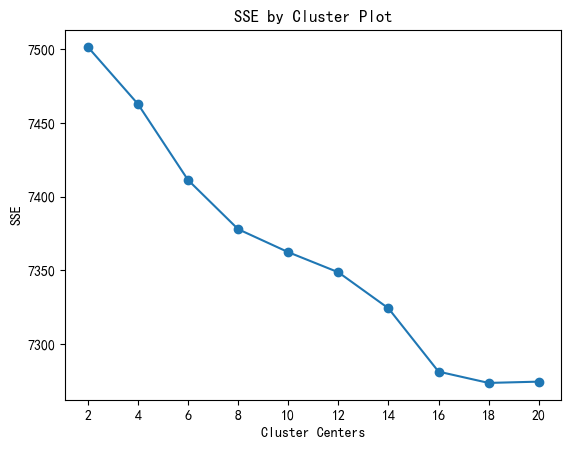

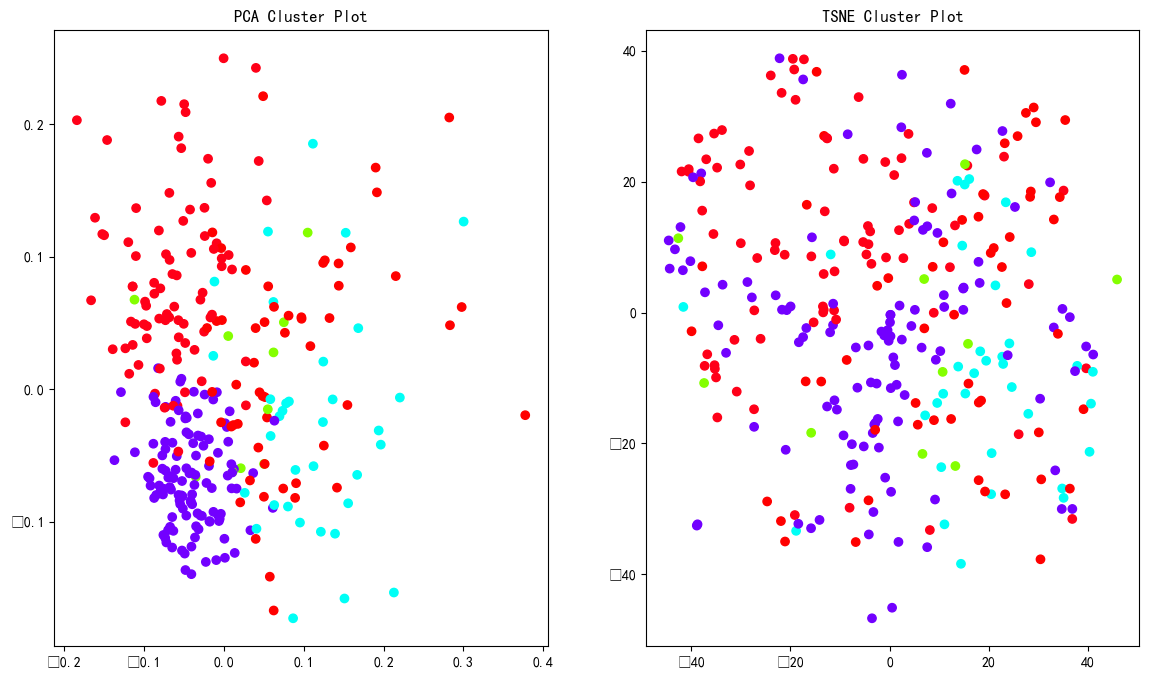

In [3]:
# if __name__=='__main__':
td = Text_Classfier_Data()
td.data_info()
td.distri_label()
td.clear_content()
td.cut_sentence()
td.remove_stoplist()
text = td.get_text_vector(5,0.95,8000)
td.find_optimal_clusters(text,20)
clusters = MiniBatchKMeans(n_clusters = 5,init_size = 1024,batch_size = 2048,random_state = 20).fit_predict(text)
td.plot_tnse_pca(text,clusters)

In [4]:
td.get_top_keywords(text,clusters,td.tfidf.get_feature_names_out(),10)
km = MiniBatchKMeans(n_clusters = 5,init_size = 1024,batch_size = 1024,random_state = 20).fit(text)
td.df['cluster'] = km.labels_
td.df['label'].value_counts()
td.df[td.df['label'] == 0].value_counts()
con_df = td.get_balance_distri()
print(' ------------new data distribution---------')
print(con_df['label'].value_counts())
td.split_data(con_df)
td.store_data()
print('finished')


 Cluster 0
还会,环境,位置,下次,设施,房间,早餐,酒店,不错,服务

 Cluster 1
价格,干净,服务,房间,值得,不错,推荐,舒适,酒店,特别

 Cluster 2
干净,服务,早餐,环境,价格,总体,酒店,房间,感觉,不错

 Cluster 3
晚上,不好,携程,价格,设施,早餐,服务,酒店,宾馆,房间

 Cluster 4
感觉,年月日,服务员,客人,携程,前台,服务,房间,入住,酒店
 ------------new data distribution---------
1    5322
0    4888
Name: label, dtype: int64
finished


In [9]:
def DataLoader():
    tokenize = lambda x:x.split()
    REVIEW = data.Field(sequential = True,tokenize = tokenize,fix_length = 256)
    LABEL = data.LabelField(sequential = False,use_vocab = False)

    train_data,valid_data,test_data = data.TabularDataset.splits(
                                     path = 'data',
                                     train = 'train.csv',
                                     validation = 'valid.csv',test = 'test.csv',
                                     format = 'csv',
                                     fields = [('review',REVIEW),('label',LABEL)],
                                     skip_header = True)
    return REVIEW,LABEL,train_data,valid_data,test_data

In [10]:
REVIEW,LABEL,train_data,valid_data,test_data = DataLoader()
REVIEW.build_vocab(train_data)

In [17]:
train_iter,val_iter,test_iter = data.BucketIterator.splits((train_data,valid_data,test_data),
                                                    batch_size = 64,
                                                    sort = False,
                                                    sort_within_batch = False,repeat = False)
def getTEXT():
    return REVIEW
def getLABEL():
    return LABEL
def getIter():
    return train_iter,val_iter,test_iter

In [22]:
batch = next(test_iter.__iter__())

In [23]:
batch


[torchtext.data.batch.Batch of size 64]
	[.review]:[torch.LongTensor of size 256x64]
	[.label]:[torch.LongTensor of size 64]

In [24]:
class Config():
    def __init__(self):
        self.class_num = 2
        self.fix_length = 256
        self.batch_size = 256
        # data label list
        self.label_list = ['好', '差']
        class_number = len(self.label_list)
        # train details
        self.epochs = 10
        self.learning_rate = 1e-4
args = Config()

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy


class Transformer(nn.Module):
    def __init__(self,
                 vocab_size = len(getTEXT().vocab),  # 词典的大小
                 seq_len = 256,
                 n_class = args.class_num,  # 分类的类型
                 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
                 embed_dim=256,  # embedding的维度
                 dim_model=256,
                 dropout=0.2,
                 num_head=8,
                 hidden=512,
                 num_encoder=4,
                 ):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.postion_embedding = Positional_Encoding(embed_dim, seq_len, dropout, device)
        self.encoder = Encoder(dim_model, num_head, hidden, dropout)
        self.encoders = nn.ModuleList([
            copy.deepcopy(self.encoder)
            for _ in range(num_encoder)])
        self.fc1 = nn.Linear(seq_len * dim_model, n_class)

    def forward(self, x):
        out = self.embedding(x)
        out = self.postion_embedding(out)
        for encoder in self.encoders:
            out = encoder(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out


class Encoder(nn.Module):
    def __init__(self, dim_model, num_head, hidden, dropout):
        super(Encoder, self).__init__()
        self.attention = Multi_Head_Attention(dim_model, num_head, dropout)
        self.feed_forward = Position_wise_Feed_Forward(dim_model, hidden, dropout)

    def forward(self, x):
        out = self.attention(x)
        out = self.feed_forward(out)

        return out


class Positional_Encoding(nn.Module):
    def __init__(self, embed, pad_size, dropout, device):
        super(Positional_Encoding, self).__init__()
        self.device = device
        self.pe = torch.tensor(
            [[pos / (10000.0 ** (i // 2 * 2.0 / embed)) for i in range(embed)] for pos in range(pad_size)])
        self.pe[:, 0::2] = np.sin(self.pe[:, 0::2])
        self.pe[:, 1::2] = np.cos(self.pe[:, 1::2])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = x + nn.Parameter(self.pe, requires_grad=False).to(self.device)
        out = self.dropout(out)
        return out


class Scaled_Dot_Product_Attention(nn.Module):
    '''Scaled Dot-Product Attention '''

    def __init__(self):
        super(Scaled_Dot_Product_Attention, self).__init__()

    def forward(self, Q, K, V, scale=None):
        '''
        Args:
            Q: [batch_size, len_Q, dim_Q]
            K: [batch_size, len_K, dim_K]
            V: [batch_size, len_V, dim_V]
            scale: 缩放因子 论文为根号dim_K
        Return:
            self-attention后的张量，以及attention张量
        '''
        attention = torch.matmul(Q, K.permute(0, 2, 1))
        if scale:
            attention = attention * scale
        # if mask:  # TODO change this
        #     attention = attention.masked_fill_(mask == 0, -1e9)
        attention = F.softmax(attention, dim=-1)
        context = torch.matmul(attention, V)
        return context


class Multi_Head_Attention(nn.Module):
    def __init__(self, dim_model, num_head, dropout=0.0):
        super(Multi_Head_Attention, self).__init__()
        self.num_head = num_head
        assert dim_model % num_head == 0
        self.dim_head = dim_model // self.num_head
        self.fc_Q = nn.Linear(dim_model, num_head * self.dim_head)
        self.fc_K = nn.Linear(dim_model, num_head * self.dim_head)
        self.fc_V = nn.Linear(dim_model, num_head * self.dim_head)
        self.attention = Scaled_Dot_Product_Attention()
        self.fc = nn.Linear(num_head * self.dim_head, dim_model)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(dim_model)

    def forward(self, x):
        batch_size = x.size(0)
        Q = self.fc_Q(x)
        K = self.fc_K(x)
        V = self.fc_V(x)
        Q = Q.view(batch_size * self.num_head, -1, self.dim_head)
        K = K.view(batch_size * self.num_head, -1, self.dim_head)
        V = V.view(batch_size * self.num_head, -1, self.dim_head)
        # if mask:  # TODO
        #     mask = mask.repeat(self.num_head, 1, 1)  # TODO change this
        scale = K.size(-1) ** -0.5  # 缩放因子
        context = self.attention(Q, K, V, scale)

        context = context.view(batch_size, -1, self.dim_head * self.num_head)
        out = self.fc(context)
        out = self.dropout(out)
        out = out + x  # 残差连接
        out = self.layer_norm(out)
        return out


class Position_wise_Feed_Forward(nn.Module):
    def __init__(self, dim_model, hidden, dropout=0.0):
        super(Position_wise_Feed_Forward, self).__init__()
        self.fc1 = nn.Linear(dim_model, hidden)
        self.fc2 = nn.Linear(hidden, dim_model)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(dim_model)

    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = out + x  # 残差连接
        out = self.layer_norm(out)
        return out

In [26]:
def test_model(test_iter, name, device,args):
    model = torch.load('done_model/'+name+'_model.pkl')
    model = model.to(device)
    model.eval()
    total_loss = 0.0
    accuracy = 0
    y_true = []
    y_pred = []
    total_test_num = len(test_iter.dataset)
    for batch in test_iter:
        feature = batch.review
        target = batch.label
        with torch.no_grad():
            feature = torch.t(feature)
        feature, target = feature.to(device), target.to(device)
        out = model(feature)
        loss = F.cross_entropy(out, target)
        total_loss += loss.item()
        accuracy += (torch.argmax(out, dim=1)==target).sum().item()
        y_true.extend(target.cpu().numpy())
        y_pred.extend(torch.argmax(out, dim=1).cpu().numpy())
    print('>>> Test loss:{}, Accuracy:{} \n'.format(total_loss/total_test_num, accuracy/total_test_num))
    score = accuracy_score(y_true, y_pred)
    print(score)
    from sklearn.metrics import classification_report
    print(classification_report(y_true, y_pred, target_names = args.label_list, digits=3))

def train_model(train_iter, dev_iter, model, name, device,args):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = args.learning_rate)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.6)
    model.train()
    best_acc = 0
    print('training...')
    for epoch in range(1, args.epochs + 1):
        model.train()
        total_loss = 0.0
        accuracy = 0
        total_train_num = len(train_iter.dataset)
        progress_bar = tqdm(enumerate(train_iter), total=len(train_iter))
        for i,batch in progress_bar:
            feature = batch.review
            target = batch.label
            with torch.no_grad():
                feature = torch.t(feature)
            feature, target = feature.to(device), target.to(device)
            optimizer.zero_grad()
            logit = model(feature)
            loss = F.cross_entropy(logit, target)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            accuracy += (torch.argmax(logit, dim=1) == target).sum().item()
            progress_bar.set_description(
            f'loss: {loss.item():.3f}')
        print('>>> Epoch_{}, Train loss is {}, Accuracy:{} \n'.format(epoch,loss.item()/total_train_num, accuracy/total_train_num))
        model.eval()
        total_loss = 0.0
        accuracy = 0
        total_valid_num = len(dev_iter.dataset)
        progress_bar = tqdm(enumerate(dev_iter), total=len(dev_iter))
        for i, batch in progress_bar:
            feature = batch.review  # (W,N) (N)
            target = batch.label
            with torch.no_grad():
                feature = torch.t(feature)
            feature, target = feature.to(device), target.to(device)
            out = model(feature)
            loss = F.cross_entropy(out, target)
            total_loss += loss.item()
            accuracy += (torch.argmax(out, dim=1)==target).sum().item()
        print('>>> Epoch_{}, Valid loss:{}, Accuracy:{} \n'.format(epoch, total_loss/total_valid_num, accuracy/total_valid_num))
        if(accuracy/total_valid_num > best_acc):
            print('save model...')
            best_acc = accuracy/total_valid_num
            saveModel(model, name=name)

def saveModel(model,name):
    torch.save(model, 'done_model/'+name+'_model.pkl')

name = 'Transformer'
model = Transformer()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
train_iter, val_iter, test_iter = getIter()

if __name__ == '__main__':
    train_model(train_iter, val_iter, model, name, device,args)
    test_model(test_iter, name, device,args)

cpu
training...


loss: 0.615: 100%|███████████████████████████████████████████████████████████████████| 125/125 [15:42<00:00,  7.54s/it]


>>> Epoch_1, Train loss is 7.690055668354034e-05, Accuracy:0.62975 



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:10<00:00,  4.39s/it]


>>> Epoch_1, Valid loss:0.02121012282371521, Accuracy:0.043 

save model...


loss: 0.623: 100%|███████████████████████████████████████████████████████████████████| 125/125 [15:40<00:00,  7.52s/it]


>>> Epoch_2, Train loss is 7.787635922431946e-05, Accuracy:0.6655 



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:48<00:00,  3.03s/it]


>>> Epoch_2, Valid loss:0.01936793267726898, Accuracy:0.076 

save model...


loss: 0.466: 100%|███████████████████████████████████████████████████████████████████| 125/125 [15:30<00:00,  7.44s/it]


>>> Epoch_3, Train loss is 5.828285962343216e-05, Accuracy:0.704125 



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:49<00:00,  3.07s/it]


>>> Epoch_3, Valid loss:0.01965293252468109, Accuracy:0.097 

save model...


loss: 0.438: 100%|███████████████████████████████████████████████████████████████████| 125/125 [15:47<00:00,  7.58s/it]


>>> Epoch_4, Train loss is 5.4778367280960083e-05, Accuracy:0.741375 



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:52<00:00,  3.28s/it]


>>> Epoch_4, Valid loss:0.010011493623256684, Accuracy:0.598 

save model...


loss: 0.352: 100%|███████████████████████████████████████████████████████████████████| 125/125 [16:42<00:00,  8.02s/it]


>>> Epoch_5, Train loss is 4.397478699684143e-05, Accuracy:0.77675 



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:58<00:00,  3.64s/it]


>>> Epoch_5, Valid loss:0.0049658635258674625, Accuracy:0.934 

save model...


loss: 0.507: 100%|███████████████████████████████████████████████████████████████████| 125/125 [16:42<00:00,  8.02s/it]


>>> Epoch_6, Train loss is 6.343073397874832e-05, Accuracy:0.781625 



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:52<00:00,  3.27s/it]


>>> Epoch_6, Valid loss:0.0073105769455432896, Accuracy:0.803 



loss: 0.277: 100%|███████████████████████████████████████████████████████████████████| 125/125 [16:22<00:00,  7.86s/it]


>>> Epoch_7, Train loss is 3.4603103995323184e-05, Accuracy:0.820875 



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:53<00:00,  3.36s/it]


>>> Epoch_7, Valid loss:0.015234131932258605, Accuracy:0.399 



loss: 0.278: 100%|███████████████████████████████████████████████████████████████████| 125/125 [20:57<00:00, 10.06s/it]


>>> Epoch_8, Train loss is 3.4777920693159105e-05, Accuracy:0.82375 



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:22<00:00,  5.15s/it]


>>> Epoch_8, Valid loss:0.012475114643573761, Accuracy:0.533 



loss: 0.219: 100%|███████████████████████████████████████████████████████████████████| 125/125 [24:07<00:00, 11.58s/it]


>>> Epoch_9, Train loss is 2.7436524629592894e-05, Accuracy:0.84625 



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:24<00:00,  5.31s/it]


>>> Epoch_9, Valid loss:0.008133632868528366, Accuracy:0.733 



loss: 0.328: 100%|███████████████████████████████████████████████████████████████████| 125/125 [24:14<00:00, 11.63s/it]


>>> Epoch_10, Train loss is 4.0978174656629565e-05, Accuracy:0.8555 



100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:16<00:00,  4.80s/it]


>>> Epoch_10, Valid loss:0.010352720677852631, Accuracy:0.633 

>>> Test loss:0.004848163223956242, Accuracy:0.9347107438016529 

0.9347107438016529
              precision    recall  f1-score   support

           好      1.000     0.935     0.966      1210
           差      0.000     0.000     0.000         0

    accuracy                          0.935      1210
   macro avg      0.500     0.467     0.483      1210
weighted avg      1.000     0.935     0.966      1210

